In [3]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios as mr
import create_data_for_single_gene as cdg

import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
iMs_run = ['Purine']

        
# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
true_false = []
for act, inh in zip(flags_df['act_iM'], flags_df['inh_iM']):
    if act in iMs_run or inh in iMs_run:
        true_false.append(True)
    else:
        true_false.append(False)
flags_df = flags_df.loc[true_false]
genes = flags_df.index.to_list()

t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'only_create_ratios' : True,
    'only_check_KdRNAPCrp' : True, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : False, # only used for remove_outliers right now
    'drop_basal_conds' : False,
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : genes, #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


In [13]:
# multiprocess run
gene = genes[0]

# overall setup
folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
if len(folders) == 0:
    run_ct = 1
else:
    run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
os.mkdir(new_run_folder)

# put the flags df in there
flags_df.to_csv(new_run_folder+'/saved_flags.csv')

# setup inputs
temp_flags = dict(flags_df.loc[gene])

# need to convert some flags from strings to lists
for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
    temp_flags[col] = ast.literal_eval(temp_flags[col])

# convert cell constants into a dictionary
temp_flags.update({'cell_constants' : {
    'RNAP' : stable_flags['cell_constants_RNAP'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    'cell_volume' : stable_flags['cell_constants_cell_volume'],
    'kDeg' : stable_flags['cell_constants_kDeg'],
    'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
    'u' : stable_flags['cell_constants_u'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
}})
temp_flags.update({'eq_str' : stable_flags['eq_str']})
temp_flags.update({'save_results' : stable_flags['save_results']})
temp_flags.update({'save_results_folder' : new_run_folder})
temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
temp_flags.update({'case' : stable_flags['case']})
temp_flags.update({'central_gene' : gene})
temp_flags.update({'drop_basal_conds' : stable_flags['drop_basal_conds']})

ret_figs = cdg.create_data_for_gene(temp_flags)
ratios_df = pd.read_pickle(new_run_folder+'/'+gene+'/ratios_df.pkl')

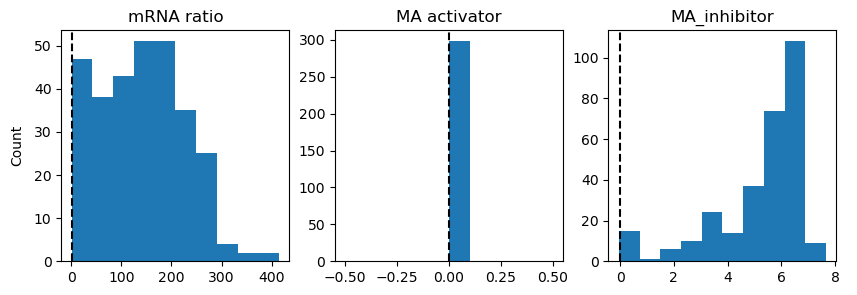

In [14]:
show_figure(ret_figs[0])

In [8]:
# load log tpm
log_tpm_df = pd.read_csv('../data/precise_1k/corrected/PRECISE_1K_log_tpm_basal.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

In [9]:
# scale and normalize it
df = 2**log_tpm_df.loc[genes].T
normalized_df=(df-df.mean())/df.std()
normalized_df = normalized_df
normalized_df['avg_exp'] = normalized_df.mean(axis = 1)
normalized_df.sort_values(by = 'avg_exp')

,b1849,b2499,b0523,b2557,b0522,b4006,b2476,b4005,b2313,b2312,b2500,b1131,avg_exp
p1k_00466,-0.632459,-0.986117,-1.154797,-0.771786,-0.911044,-0.710083,-1.508912,-0.649758,-1.606817,-1.254253,-1.775578,-1.996494,-1.163175
p1k_00465,-0.622332,-0.973848,-1.181157,-0.769537,-0.915061,-0.710482,-1.520996,-0.653292,-1.632196,-1.279116,-1.541005,-1.965108,-1.147011
p1k_00481,-0.617518,-0.926059,-1.160994,-0.736658,-0.904875,-0.639414,-1.355689,-0.595005,-1.621838,-1.207072,-1.612827,-1.935895,-1.109487
p1k_00455,-0.625854,-0.956792,-1.135751,-0.752461,-0.895237,-0.678413,-1.344079,-0.612302,-1.561640,-1.232829,-1.632037,-1.884527,-1.109327
p1k_00456,-0.590248,-0.929671,-1.167125,-0.737238,-0.880271,-0.637630,-1.247032,-0.620984,-1.614804,-1.221939,-1.583076,-1.855072,-1.090424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
starve_series__t21_growth2,7.027986,13.846519,12.765292,10.772806,10.626805,7.296812,5.438112,5.705518,6.775752,10.346580,10.018875,8.105540,9.060550
starve_series__t00_growth1,5.715073,17.097561,15.344980,9.511185,15.429512,8.383595,10.698762,7.594000,6.731313,6.421365,11.462728,4.978746,9.947402
starve_series__t25_growth2,12.580130,9.950915,10.434370,13.366351,11.743773,13.102399,10.845451,13.174390,9.509681,13.913053,10.500972,7.207104,11.360716
starve_series__t27_growth2,13.861136,10.816106,9.483164,13.430160,11.479830,15.822966,9.287865,15.580100,9.971342,13.376226,10.898370,7.856337,11.821967


# greatly expanded and more automated search

In [31]:
# load in 
ext_flags_df = pd.read_csv('../data/saved_flags_expanded.csv', index_col = 0)

# load log tpm
log_tpm_df = pd.read_csv('../data/precise_1k/corrected/PRECISE_1K_log_tpm_basal.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

gene_to_basal_conds = {}
for act_iM in set(ext_flags_df.act_iM):
    # first let's filter out genes with activator and inhibitor
    baby_df = ext_flags_df[ext_flags_df['act_iM'] == act_iM]
    baby_df = baby_df[[type(val) == float for val in baby_df['inh_iM']]]

    # scale and normalize it
    df = 2**log_tpm_df.loc[baby_df.index].T
    normalized_df=(df-df.mean())/df.std()
    normalized_df = normalized_df
    normalized_df['avg_exp'] = normalized_df.mean(axis = 1)
    normalized_df = normalized_df.sort_values(by = 'avg_exp')
    
    # it's an activator, so we want the lowest expression as basal
    basal = normalized_df.index[0]
    
    for gene in baby_df.index:
        gene_to_basal_conds.update({gene : [basal]})
for inh_iM in set(ext_flags_df.inh_iM):
    # first let's filter out genes with activator and inhibitor
    baby_df = ext_flags_df[ext_flags_df['inh_iM'] == inh_iM]
    baby_df = baby_df[[type(val) == float for val in baby_df['act_iM']]]

    # scale and normalize it
    df = 2**log_tpm_df.loc[baby_df.index].T
    normalized_df=(df-df.mean())/df.std()
    normalized_df = normalized_df
    normalized_df['avg_exp'] = normalized_df.mean(axis = 1)
    normalized_df = normalized_df.sort_values(by = 'avg_exp')
    
    # it's an inhibitor, so we want the highest expression as basal
    basal = normalized_df.index[-1]
    
    for gene in baby_df.index:
        gene_to_basal_conds.update({gene : [basal]})
        
missing = list(set(ext_flags_df.index) - set(gene_to_basal_conds.keys()))
act_inh_iMs = set([(row['act_iM'], row['inh_iM']) for _, row in ext_flags_df.loc[missing].iterrows()])
for act_iM, inh_iM in act_inh_iMs:
    # gather all matching
    baby_df = ext_flags_df[ext_flags_df['act_iM'] == act_iM]
    baby_df = baby_df[baby_df['inh_iM'] == inh_iM]
    
    # scale and normalize it
    df = 2**log_tpm_df.loc[baby_df.index].T
    normalized_df=(df-df.mean())/df.std()
    normalized_df = normalized_df
    normalized_df['avg_exp'] = normalized_df.mean(axis = 1)
    normalized_df = normalized_df.sort_values(by = 'avg_exp')
    
    # this is both activator and inhibitor, for now let's take the median expression value
    basal = normalized_df.loc[normalized_df['avg_exp'] == normalized_df['avg_exp'].median()].index[0]
    
    for gene in baby_df.index:
        gene_to_basal_conds.update({gene : [basal]})

baby_ext_flags_df = ext_flags_df.loc[gene_to_basal_conds.keys()]
baby_ext_flags_df['basal_conditions'] = gene_to_basal_conds.values()
baby_ext_flags_df.to_csv('../data/saved_flags_expanded_filtered.csv')

In [38]:
missing = list(set(ext_flags_df.index) - set(gene_to_basal_conds.keys()))
ext_flags_df.loc[missing].sort_values(by = 'inh_iM')

# eh - let's deal with these later, picking basal conditions for them is much more complex than worth dealing with right now

,include,force_rerun,sanity_plots,act_iM,inh_iM,basal_conditions,grid_use,basal_bool,basal_or_hard_val,hard_val,...,lambda_,cxpb,cx_prob,mutpb,mt_prob,n_gen,verbose,n_iter,max_steps,n_rounds
b1298,False,True,True,Putrescine,ArcA,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b0313,False,True,True,minicoli KOs,ArcA,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b2980,False,True,True,Crp-1,ArcA,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b1276,False,True,True,SoxS,ArcA,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b0314,False,True,True,minicoli KOs,ArcA,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b0970,False,True,True,CpxR,nquinone ALE 3,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b2343,False,True,True,Fnr-3,nquinone ALE 3,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b1641,False,True,True,Magnesium,nquinone ALE 3,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100
b0168,False,True,True,SoxS,nquinone ALE 3,NaN,8,False,basal,10,...,100,0.6,0.6,0.4,0.1,100,False,5,30,100


In [29]:
normalized_df.index[0]

'p1k_00844'

In [10]:
float('nan')

nan

In [14]:
type(baby_df['inh_iM'].values[0])

float